In [1]:
!pip install --user xgboost

!pip install --user hyperopt

In [2]:
import numpy as np 
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
# from sklearn.linear_model import LassoCV
# from sklearn import metrics 
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import KFold
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from scipy.stats import skew  # for some statistics
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, ElasticNet
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# from mlxtend.regressor import StackingCVRegressor


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# from scipy.stats import skew

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
plot_flag = True

./input/predict_data.csv
./input/data_description.txt
./input/train.csv
./input/historical_data.csv
./input/test.csv


## Reading and Comprehending Data

### Reading Data

In [3]:
train = pd.read_csv('./input/historical_data.csv')
test = pd.read_csv('./input/predict_data.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   market_id                                     54528 non-null  float64
 1   created_at                                    54778 non-null  object 
 2   store_id                                      54778 non-null  int64  
 3   store_primary_category                        53435 non-null  object 
 4   order_protocol                                54495 non-null  float64
 5   total_items                                   54778 non-null  int64  
 6   subtotal                                      54778 non-null  int64  
 7   num_distinct_items                            54778 non-null  int64  
 8   min_item_price                                54778 non-null  int64  
 9   max_item_price                                54778 non-null 

### Checking for Missing Values in output

In [6]:
null = pd.DataFrame(data={'Train Null Percentage': 
                          train.isnull().sum()[train.isnull().sum() > 0], 
                          'Test Null Percentage': test.isnull().sum()[test.isnull().sum() > 0]})
null.sort_values(by='Train Null Percentage',ascending=False)

,Train Null Percentage,Test Null Percentage
total_busy_dashers,16262,4633.0
total_onshift_dashers,16262,4633.0
total_outstanding_orders,16262,4633.0
store_primary_category,4760,1343.0
order_protocol,995,283.0
market_id,987,250.0
estimated_store_to_consumer_driving_duration,526,11.0
actual_delivery_time,7,NaN


Out 197428 samples, there are 7 missing "actual_delivery_time". We can drop those samples.

In [7]:
train.dropna(subset=['actual_delivery_time'],inplace=True)

### Construct output variable

In [8]:
train[['created_at','actual_delivery_time']] =train[['created_at','actual_delivery_time']].apply(pd.to_datetime)
test[['created_at']] =test[['created_at']].apply(pd.to_datetime)

In [9]:
train['duration'] = (train['actual_delivery_time']-train['created_at']).astype('timedelta64[s]')
train[['created_at','actual_delivery_time','duration']].head()

,created_at,actual_delivery_time,duration
0,2015-02-06 22:24:17,2015-02-06 23:27:16,3779.0
1,2015-02-10 21:49:25,2015-02-10 22:56:29,4024.0
2,2015-01-22 20:39:28,2015-01-22 21:09:09,1781.0
3,2015-02-03 21:21:45,2015-02-03 22:13:00,3075.0
4,2015-02-15 02:40:36,2015-02-15 03:20:26,2390.0


After creating the output variable `duration`, the old column `actual_delivery_time` can be dropped. But there might be some information left in `created_at`, for example,the time of the order created. If it's in the midnight, it might take longer for a store to prepare the order, although there are not many other outstanding orders. So we extract the `hour` from the `created_at` as our new feature. 

In [10]:
train['created_at_hour'] = train['created_at'].dt.hour
# train_processed = train.drop(['created_at','actual_delivery_time'], axis=1).copy()
test['created_at_hour'] = test['created_at'].dt.hour
# train_processed = train.drop(['created_at','actual_delivery_time'], axis=1).copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197421 entries, 0 to 197427
Data columns (total 18 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196434 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197421 non-null  int64         
 4   store_primary_category                        192661 non-null  object        
 5   order_protocol                                196426 non-null  float64       
 6   total_items                                   197421 non-null  int64         
 7   subtotal                                      197421 non-null  int64         
 8   num_distinct_items                            197421 n

## Data Visualization

### Distribution of Output

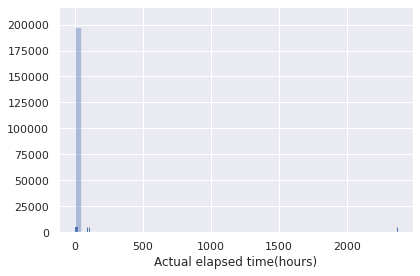

In [11]:
if plot_flag:
    fig = plt.figure(figsize=(6,4))
    fig.add_subplot(1,1,1)
    sns.distplot(train['duration']/3600, rug=True, hist=True, label='UW', kde=False)
    plt.xlabel('Actual elapsed time(hours)')
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/y_original.pdf',bbox_inches='tight')

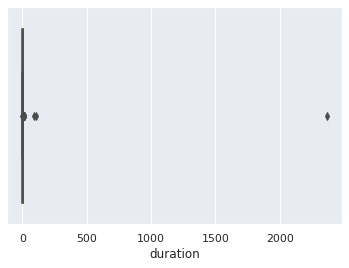

In [12]:
if plot_flag:
    sns.boxplot(x=train['duration']/3600)
    plt.savefig('./figures/y_original_box.pdf',bbox_inches='tight')

### Outliers of Output

From the above figure, we can see clearly that there are outliers for `duration`. Now let's zoom in the  fat tail.

In [13]:
possible_outliers = train[(train['duration']>4.0*3600)]

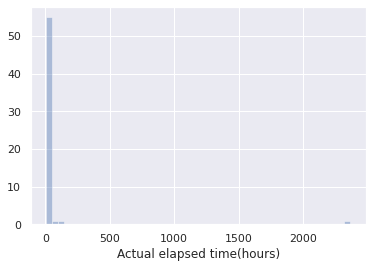

In [14]:
if plot_flag:
    ds = train
    fig = plt.figure(figsize=(6,4))
    fig.add_subplot(1,1,1)
    sns.distplot(possible_outliers['duration']/3600,kde=False)
    plt.xlabel('Actual elapsed time(hours)')
    plt.show()
    fig.savefig('./figures/y_tail.pdf',bbox_inches='tight')

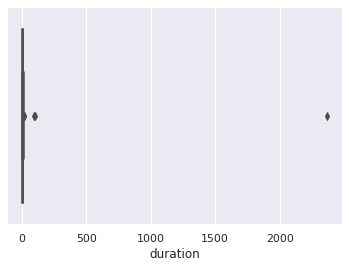

In [15]:
if plot_flag:
    sns.boxplot(x=possible_outliers['duration']/3600)
    plt.savefig('./figures/y_tail_box.pdf',bbox_inches='tight')

In the figure above, we can see that there are samples with more than 2000 hours of delivery time. Let's take a closer look at those outliers.

In [16]:
possible_outliers.sort_values(by='duration', ascending=False).head(3)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,duration,created_at_hour
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0,8516859.0,5
185550,4.0,2015-01-28 08:34:06,2015-02-01 16:25:25,6503,dessert,5.0,3,1520,3,220,750,0.0,0.0,0.0,251,476.0,373879.0,8
27189,1.0,2015-02-16 02:24:09,2015-02-19 22:45:31,4338,indian,3.0,4,4980,4,995,1795,72.0,68.0,104.0,251,767.0,332482.0,2


Take the top case as an example, the order was created at 2014-10-19 but was actually delivered at 2015-01-25. This must be a scheduled delivery which means the customer asked the store to deliver on that specific day. This kind of cases cannot be predicted by any model, so we want to exclude this kind of outliers. I choose **4 hours** as the cutoff. People usually won't wait for more than 4 hours without canceling the order unless that's the time they scheduled in advance.

In [17]:
num_outliers = len(train[(train['duration']>4*3600)])
print(f'There are {num_outliers} samples with duration more than 4 hours')

There are 58 samples with duration more than 4 hours


In [18]:
train = train[train['duration']<4*3600]

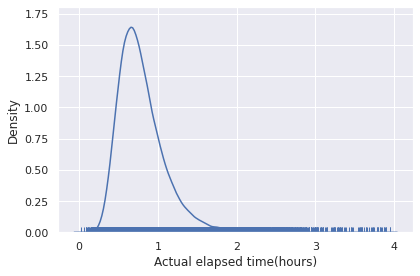

In [19]:
if plot_flag:
    fig = plt.figure(figsize=(6,4))
    fig.add_subplot(1,1,1)
    sns.distplot(train['duration']/3600, rug=True, hist=False, label='UW', kde_kws={'bw':0.1})
    plt.xlabel('Actual elapsed time(hours)')
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/y_filtered.pdf',bbox_inches='tight')

### Distribution of Features

In [20]:
categorical_features = ['created_at_hour', 'order_protocol', 'store_id', 'market_id', 'store_primary_category']
numerical_features = train.drop(categorical_features+['duration','created_at','actual_delivery_time'], 
                                axis=1).columns.tolist()
print(f'There are {len(numerical_features)} numerical features:')
print(numerical_features)
print(f'There are {len(categorical_features)} categorical features:')
print(categorical_features)

There are 10 numerical features:
['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']
There are 5 categorical features:
['created_at_hour', 'order_protocol', 'store_id', 'market_id', 'store_primary_category']


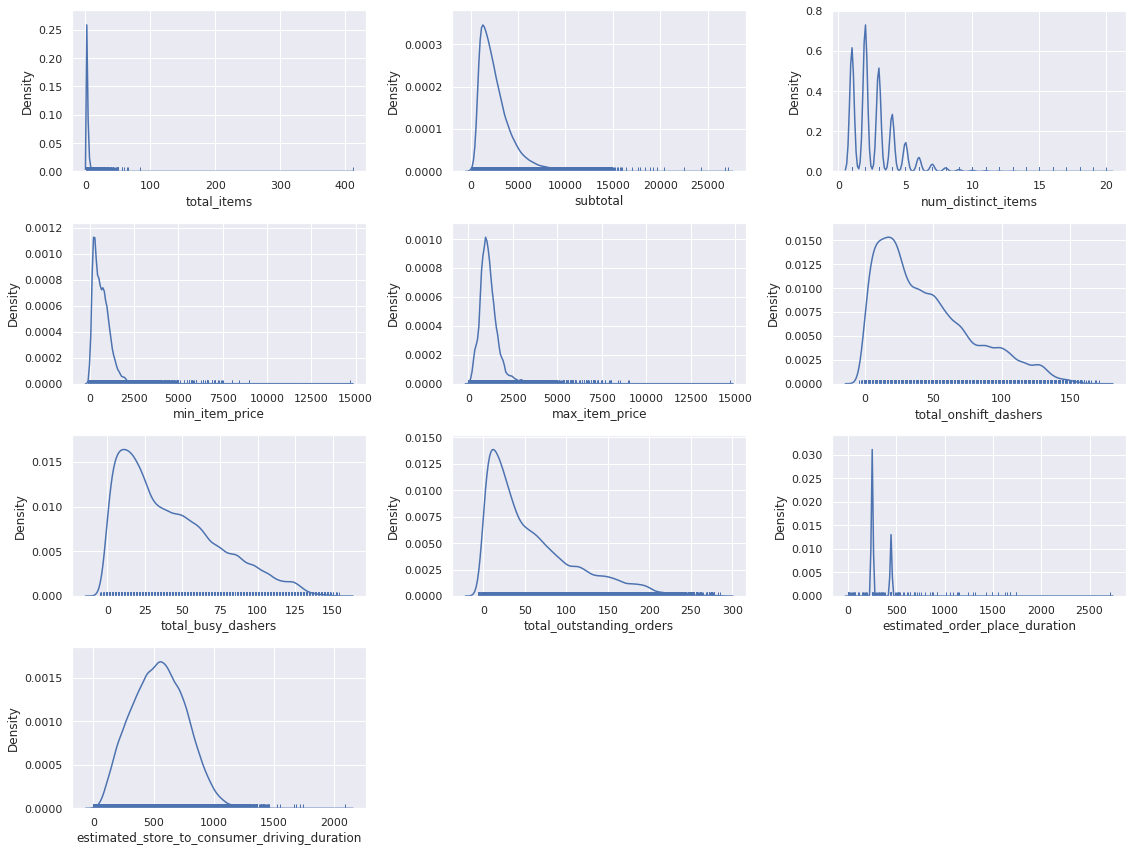

In [21]:
if plot_flag:
    fig = plt.figure(figsize=(16,12))
    for i,f in enumerate(numerical_features):
        fig.add_subplot(4,3,i+1)
        sns.distplot(train[f].dropna(), rug=True, hist=False, label='UW', kde_kws={'bw':0.1})
        plt.xlabel(f)
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/num_feature_dist.png',bbox_inches='tight')

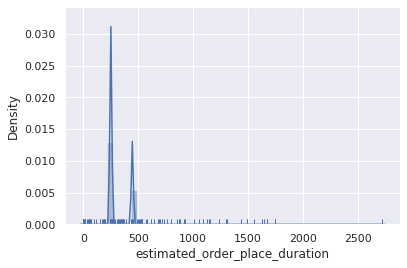

In [22]:
if plot_flag:
    sns.distplot(train['estimated_order_place_duration'].dropna(), rug=True, hist=True, kde_kws={'bw':0.1})
    plt.savefig('./figures/order_place_duration.pdf',bbox_inches='tight')

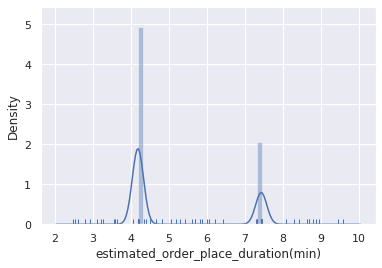

In [23]:
if plot_flag:
    ds = train['estimated_order_place_duration']
    sns.distplot(ds.loc[(ds<600) & (ds>120)].dropna()/60, rug=True, hist=True, kde_kws={'bw':0.1})
    plt.xlabel('estimated_order_place_duration(min)')
    plt.savefig('./figures/order_place_duration.pdf',bbox_inches='tight')

### Bivariate Analysis

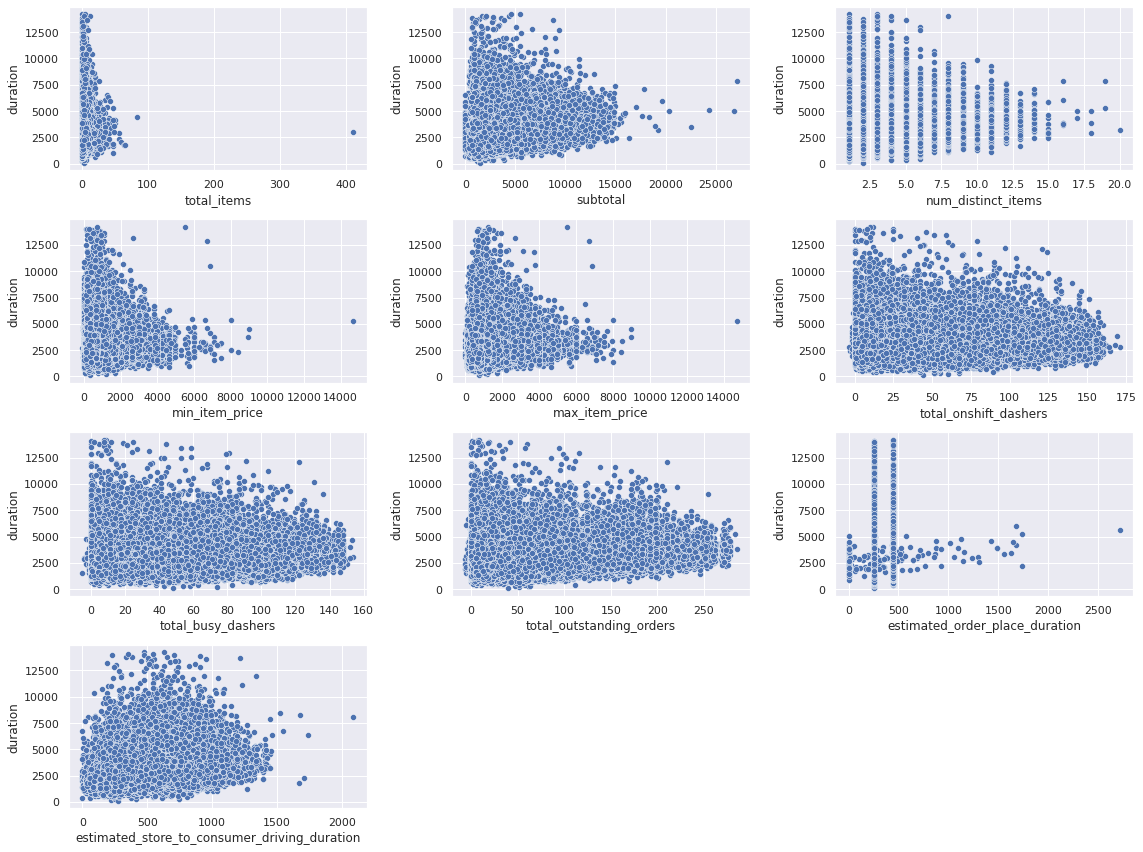

In [24]:
if plot_flag:
    fig = plt.figure(figsize=(16,12))
    for i,f in enumerate(numerical_features):
        fig.add_subplot(4, 3, i+1)
        sns.scatterplot(train[f],train['duration'] )
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/bivariate_num.png',bbox_inches='tight')

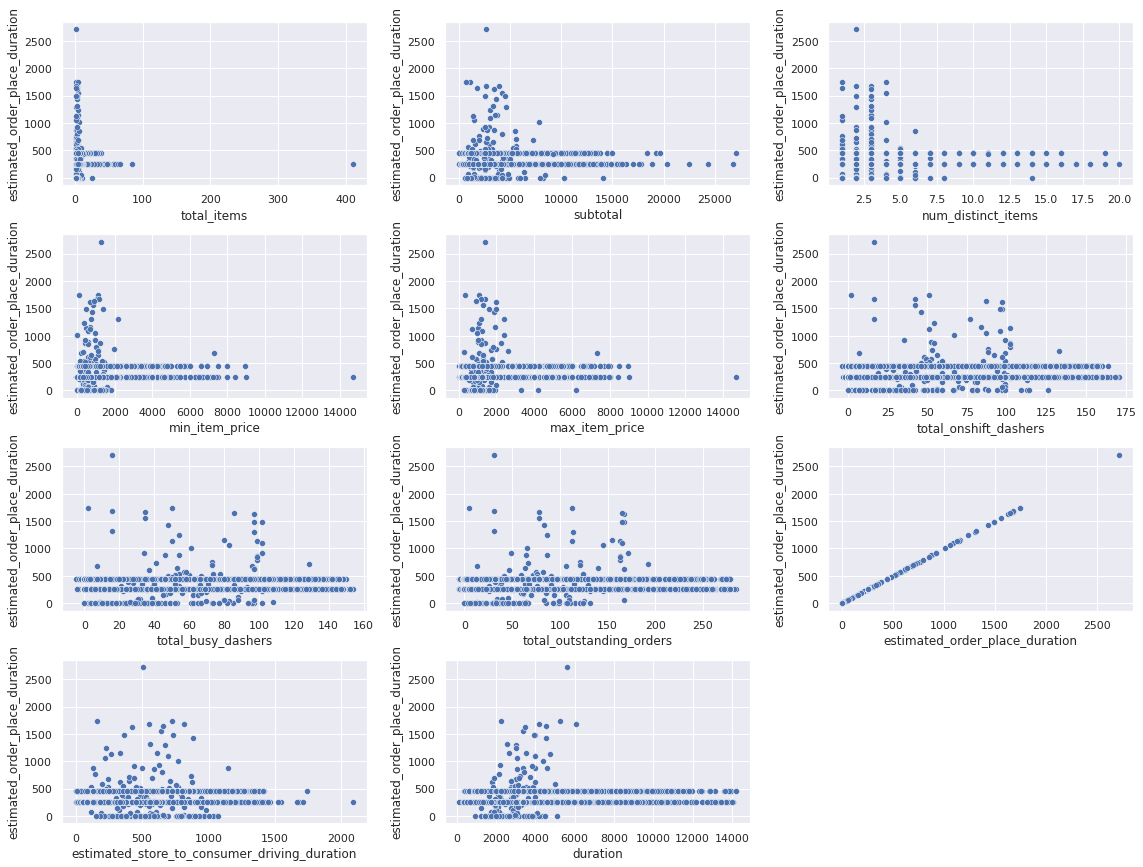

In [25]:
if plot_flag:
    fig = plt.figure(figsize=(16,12))
    for i,f in enumerate(numerical_features+['duration']):
        fig.add_subplot(4, 3, i+1)
        sns.scatterplot(train[f],train['estimated_order_place_duration'] )
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/num_order_place_duration.png',bbox_inches='tight')

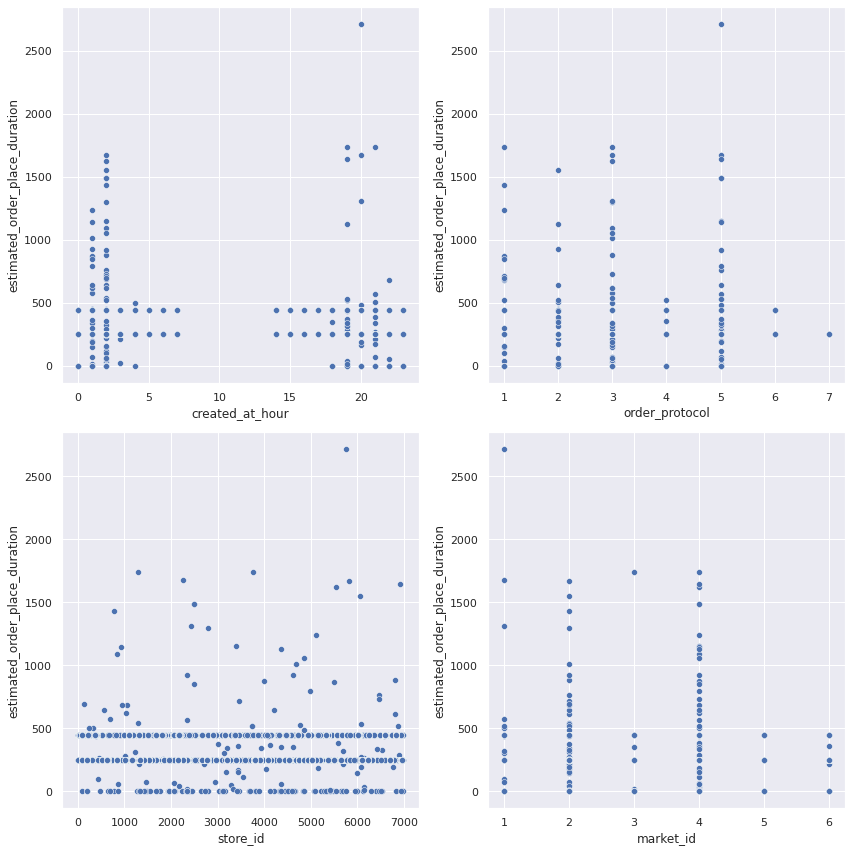

In [26]:
if plot_flag:
    fig = plt.figure(figsize=(12,12))
    for i,f in enumerate(categorical_features[:-1]):
        fig.add_subplot(2, 2, i+1)
        sns.scatterplot(train[f],train['estimated_order_place_duration'] )
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/cat_order_place.png',bbox_inches='tight')

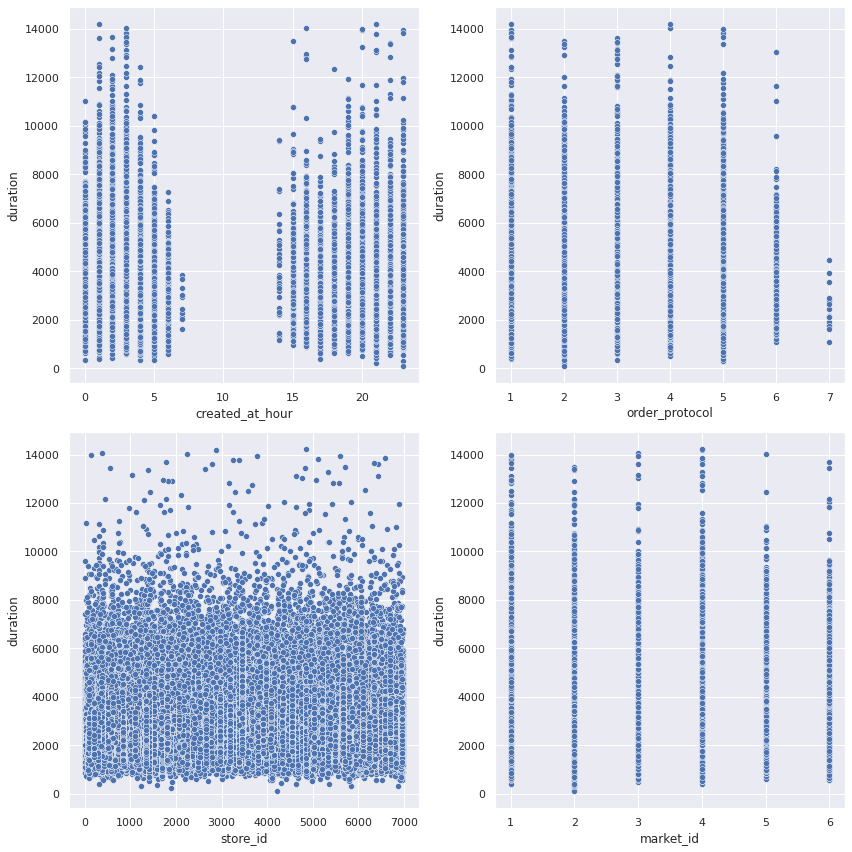

In [27]:
if plot_flag:
    fig = plt.figure(figsize=(12,12))
    for i,f in enumerate(categorical_features[:-1]):
        fig.add_subplot(2, 2, i+1)
        sns.scatterplot(train[f],train['duration'] )
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/bivariate_cat.png',bbox_inches='tight')

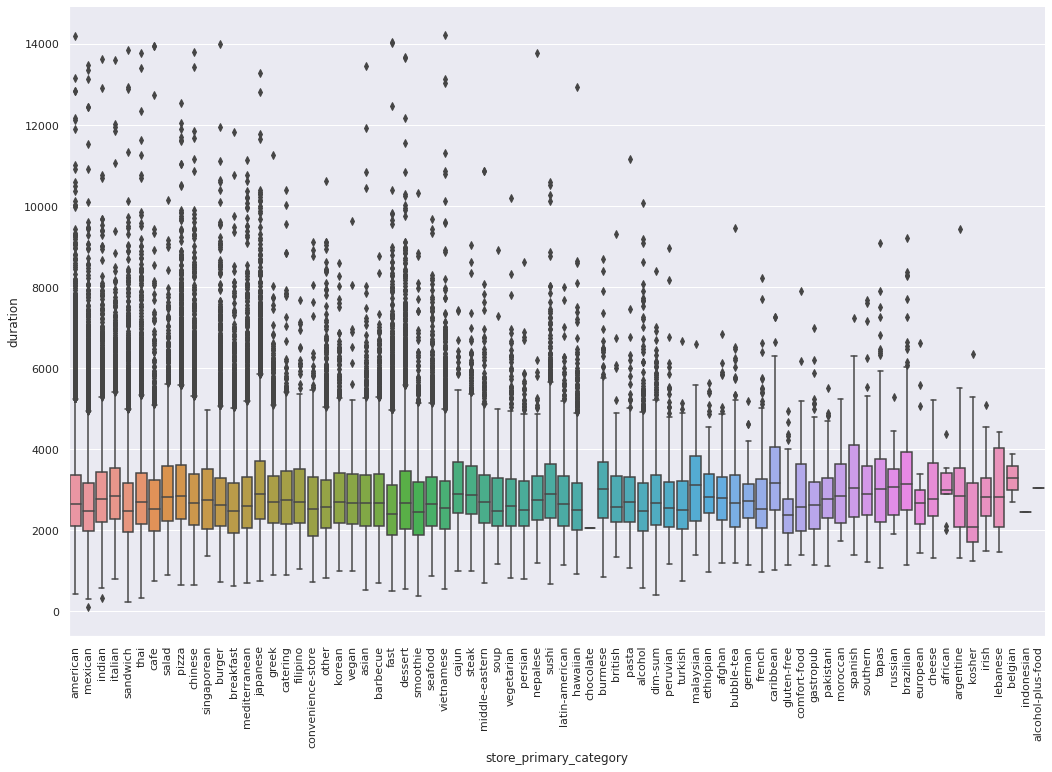

In [28]:
if plot_flag:
    ax = sns.catplot(x="store_primary_category", y="duration", kind="box", data=train)
    ax.set_xticklabels(rotation=90)
    ax.fig.set_figwidth(20)
    ax.fig.set_figheight(10)
    ax.savefig("./figures/cat_box.pdf",bbox_inches='tight')

### Outliers of features

From the figures above, we can see the following features have ourliers:
* total_items (>100)
* min_item_price (>10,000)
* max_item_price (>10,000)
* estimated_order_place_duration (>2,000)
* estimated_store_to_consumer_driving_duration

Let's take a closer look at these features

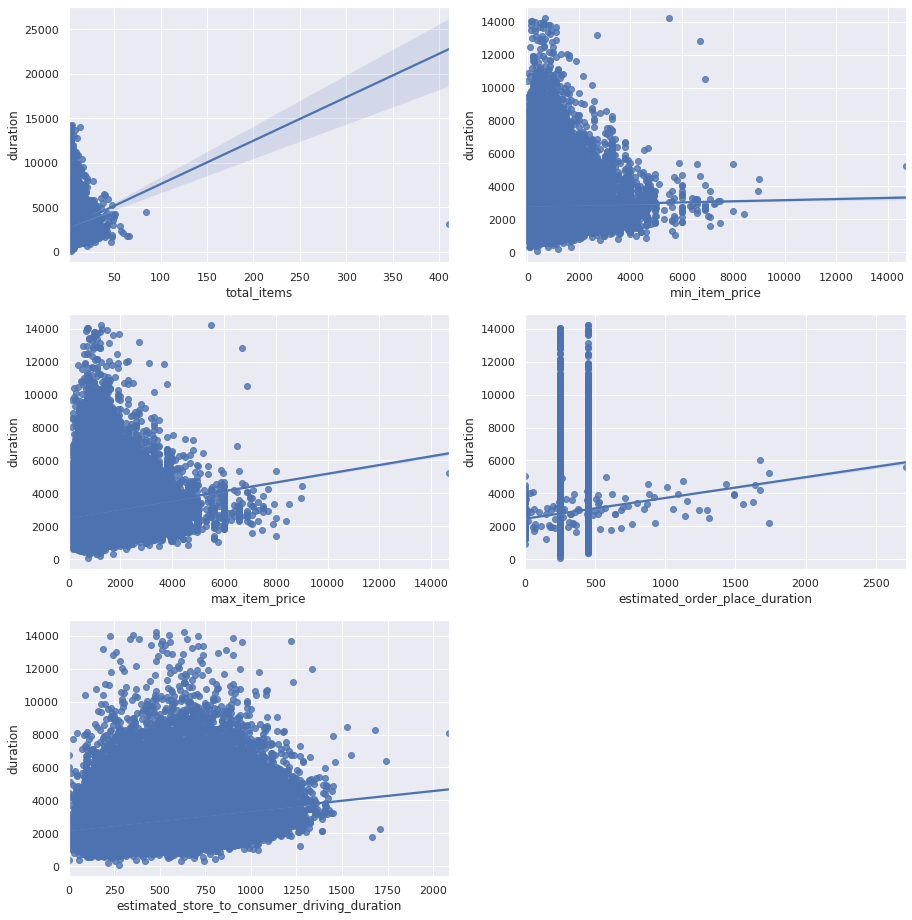

In [29]:
if plot_flag:
    ds = train
    figure, ax = plt.subplots(nrows=3, ncols=2)
    figure.set_size_inches(15,16)
    _ = sns.regplot(ds['total_items'], ds['duration'], ax=ax[0,0])
    _ = sns.regplot(ds['min_item_price'], ds['duration'], ax=ax[0,1])
    _ = sns.regplot(ds['max_item_price'], ds['duration'], ax=ax[1,0])
    _ = sns.regplot(ds['estimated_order_place_duration'], ds['duration'], ax=ax[1,1])
    _ = sns.regplot(ds['estimated_store_to_consumer_driving_duration'], ds['duration'], ax=ax[2,0])
    ax[2,1].set_visible(False)
    figure.savefig('./figures/regplot.png',bbox_inches='tight')

In [30]:
outliers = ['total_items','min_item_price','max_item_price','estimated_order_place_duration','estimated_store_to_consumer_driving_duration']
cutoffs = [100,10000,10000,2000,1500]
for o,c in zip(outliers,cutoffs):
    num_outliers = len(train[(train[o]>c)])
    print(f'There are {num_outliers} samples with {o} more than {c}')

There are 1 samples with total_items more than 100
There are 1 samples with min_item_price more than 10000
There are 1 samples with max_item_price more than 10000
There are 1 samples with estimated_order_place_duration more than 2000
There are 7 samples with estimated_store_to_consumer_driving_duration more than 1500


In [31]:
for e in numerical_features:
    num_outliers = len(train[(train[e]<0)])
    if num_outliers >0:
        print(f'There are {num_outliers} samples in training data with {e} smaller than 0')

There are 13 samples in training data with min_item_price smaller than 0
There are 21 samples in training data with total_onshift_dashers smaller than 0
There are 21 samples in training data with total_busy_dashers smaller than 0
There are 44 samples in training data with total_outstanding_orders smaller than 0


In [32]:
for e in numerical_features:
    num_outliers = len(test[(test[e]<0)])
    if num_outliers >0:
        print(f'There are {num_outliers} samples in test data with {e} smaller than 0')

There are 4 samples in test data with min_item_price smaller than 0
There are 2 samples in test data with total_onshift_dashers smaller than 0
There are 10 samples in test data with total_busy_dashers smaller than 0
There are 13 samples in test data with total_outstanding_orders smaller than 0


From these regplots we have confirmed there are outliers, so we decide to remove them.

In [33]:
for o,c in zip(outliers,cutoffs):
    train = train.drop(train[train[o]>c].index)

## Data Process

### Filling Numerical Missing data

In [34]:
ds_train = train[numerical_features]
ds_test = test[numerical_features]
null = pd.DataFrame(data={'Train Null Percentage': 
                          ds_train.isnull().mean()[ds_train.isnull().mean() > 0]*100, 
                          'Test Null Percentage': ds_test.isnull().mean()[ds_test.isnull().mean() > 0]*100})
null.sort_values(by='Train Null Percentage',ascending=False)

,Train Null Percentage,Test Null Percentage
total_onshift_dashers,8.236004,8.457775
total_busy_dashers,8.236004,8.457775
total_outstanding_orders,8.236004,8.457775
estimated_store_to_consumer_driving_duration,0.266527,0.020081


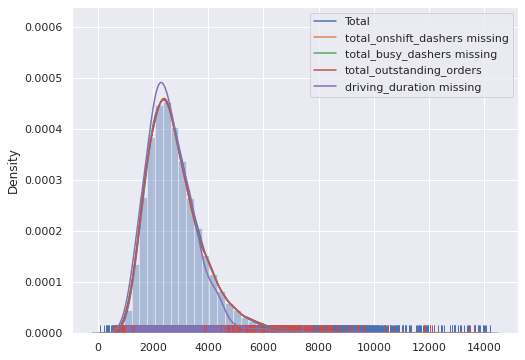

<Figure size 432x288 with 0 Axes>

In [35]:
if plot_flag:
    ds = train
    plt.figure(figsize=(8,6))
    target_0 = ds
    target_1 = ds.loc[ds['total_onshift_dashers'].isnull()]
    target_2 = ds.loc[ds['total_busy_dashers'].isnull()]
    target_3 = ds.loc[ds['total_outstanding_orders'].isnull()]
    target_4 = ds.loc[ds['estimated_store_to_consumer_driving_duration'].isnull()]
    sns.distplot(target_0[['duration']], hist=True, rug=True)
    sns.distplot(target_1[['duration']], hist=False, rug=True)
    sns.distplot(target_2[['duration']], hist=False, rug=True)
    sns.distplot(target_3[['duration']], hist=False, rug=True)
    sns.distplot(target_4[['duration']], hist=False, rug=True)
    plt.legend(labels=['Total','total_onshift_dashers missing', 'total_busy_dashers missing',
                       'total_outstanding_orders','driving_duration missing' ])
    plt.show()
    plt.savefig('./figures/missing_num_compare.pdf',bbox_inches='tight')

* From the above graph, we can see that `estimated_store_to_consumer_driving_duration` missing havs an impact on the distribution of the output. So we fill them in an specific number 0 to identify them.
* We impute `total_outstanding_orders`, `total_busy_dashers` and `total_busy_dashers` with the mean of the column

### Filling Catogorical Missing data

In [36]:
ds_train = train[categorical_features]
ds_test = test[categorical_features]
null = pd.DataFrame(data={'Train Null Percentage': 
                          ds_train.isnull().mean()[ds_train.isnull().mean() > 0]*100, 
                          'Test Null Percentage': ds_test.isnull().mean()[ds_test.isnull().mean() > 0]*100})
null.sort_values(by='Train Null Percentage',ascending=False)

,Train Null Percentage,Test Null Percentage
store_primary_category,2.411415,2.451714
order_protocol,0.504173,0.516631
market_id,0.500119,0.456388


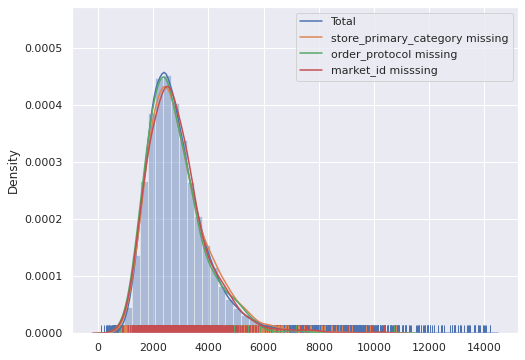

<Figure size 432x288 with 0 Axes>

In [37]:
if plot_flag:
    plt.figure(figsize=(8,6))
    target_0 = train
    target_1 = train.loc[train['store_primary_category'].isnull()]
    target_2 = train.loc[train['order_protocol'].isnull()]
    target_3 = train.loc[train['market_id'].isnull()]
    sns.distplot(target_0[['duration']], hist=True, rug=True)
    sns.distplot(target_1[['duration']], hist=False, rug=True)
    sns.distplot(target_2[['duration']], hist=False, rug=True)
    sns.distplot(target_3[['duration']], hist=False, rug=True)
    plt.legend(labels=['Total', 'store_primary_category missing', 'order_protocol missing', 'market_id misssing'])
    plt.show()
    plt.savefig('./figures/missing_cat_compare.pdf',bbox_inches='tight')

We can see the missing `store_primary_category` and `market_id` affects the output distribution. So we assign a new category for the missing rows.

In [38]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [39]:
num_mean = ['total_items', 'subtotal', 'num_distinct_items', 
            'min_item_price', 'max_item_price', 
            'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 
#             'total_busy_dashers', 'order_dasher_ratio',
            'estimated_order_place_duration']
num_constant = ['estimated_store_to_consumer_driving_duration']
cat_mode = ['created_at_hour', 'order_protocol', 'store_id']
cat_constant = ['market_id']
encode = ['store_primary_category']
features = num_mean + num_constant + cat_mode + cat_constant+ encode
num_mean_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
    ])
num_constant_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='constant', fill_value= 0)),
    ('scaler', MinMaxScaler())
    ])

cat_mode_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent'))
    ])

cat_constant_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value= 0))
    ])
encode_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value= 'Missing')),
    ('encode', OrdinalEncoder())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean', num_mean_transformer, num_mean), 
        ('num_constant', num_constant_transformer, num_constant), 
        ('cat_mean',cat_mode_transformer,cat_mode),
        ('cat_constant',cat_constant_transformer,cat_constant),
        ('encode', encode_transformer, encode)
        ])
preprocessor.fit(train[features])
col_names = get_feature_names(preprocessor)
train_processed = pd.DataFrame(preprocessor.transform(train[col_names]), columns=get_feature_names(preprocessor))
test_processed = pd.DataFrame(preprocessor.transform(test[col_names]), columns=get_feature_names(preprocessor))

In [40]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197353 entries, 0 to 197352
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   total_items                                   197353 non-null  float64
 1   subtotal                                      197353 non-null  float64
 2   num_distinct_items                            197353 non-null  float64
 3   min_item_price                                197353 non-null  float64
 4   max_item_price                                197353 non-null  float64
 5   total_onshift_dashers                         197353 non-null  float64
 6   total_busy_dashers                            197353 non-null  float64
 7   total_outstanding_orders                      197353 non-null  float64
 8   estimated_order_place_duration                197353 non-null  float64
 9   estimated_store_to_consumer_driving_duration  19

 ### Skewness of Output

In [41]:
y = train['duration']
log_y = np.log1p(y)
print(f'The skewness of y is {y.skew()}')
print(f'The skewness of log(y) is {log_y.skew()}')

The skewness of y is 1.5861931799030504
The skewness of log(y) is 0.07606673141231506


## Model Selection

In [42]:
X, y = train_processed, log_y
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=2)

def inv_y(transformed_y):
    return np.exp(transformed_y)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157882 entries, 150983 to 89256
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   total_items                                   157882 non-null  float64
 1   subtotal                                      157882 non-null  float64
 2   num_distinct_items                            157882 non-null  float64
 3   min_item_price                                157882 non-null  float64
 4   max_item_price                                157882 non-null  float64
 5   total_onshift_dashers                         157882 non-null  float64
 6   total_busy_dashers                            157882 non-null  float64
 7   total_outstanding_orders                      157882 non-null  float64
 8   estimated_order_place_duration                157882 non-null  float64
 9   estimated_store_to_consumer_driving_duration

### Elastic Net

In [44]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
elastic_cv=ElasticNetCV(alphas=alphas, cv=10)
model = elastic_cv.fit(X_train[features[:11]], y_train)
elastic = ElasticNet(alpha=model.alpha_)
elastic.fit(X_train[features[:11]], y_train )
predict = elastic.predict(X_valid[features[:11]])
insample_predict = elastic.predict(X_train[features[:11]])
print(f'MAE on training set of ElasticNet: {mean_absolute_error(inv_y(insample_predict), inv_y(y_train))}')
print(f'MAE on validation set of ElasticNet: {mean_absolute_error(inv_y(predict), inv_y(y_valid))}')
print(f'The optimal alpha is {model.alpha_}')

MAE on training set of ElasticNet: 688.8021502842223
MAE on validation set of ElasticNet: 687.3181708959701
The optimal alpha is 0.0001


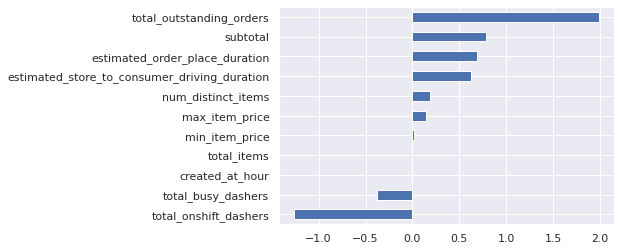

In [45]:
feature_importances = pd.Series(elastic.coef_, index=features[:11])
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh')
plt.savefig('./figures/elastic_coef.pdf',bbox_inches='tight')

### Random Forest

In [46]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
predict = rf.predict(X_valid)
insample_predict = rf.predict(X_train)
print(f'MAE on training set of Random Forest: {mean_absolute_error(inv_y(insample_predict), inv_y(y_train))}')
print(f'MAE on validation set of Random Forest: {mean_absolute_error(inv_y(predict), inv_y(y_valid))}')

MAE on training set of Random Forest: 252.6573678134955
MAE on validation set of Random Forest: 652.41234966995


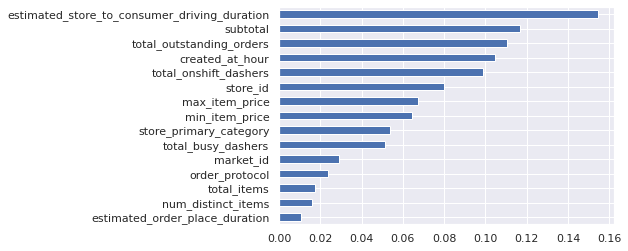

In [47]:
feature_importances = pd.Series(rf.feature_importances_, index=features)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh')
plt.savefig('./figures/rf_feat_imp.pdf',bbox_inches='tight')

### XGBoosting

In [48]:
xgb =XGBRegressor(learning_rate=0.01, n_estimators=3000,
                     max_depth=6, min_child_weight=0, subsample=0.7,
                     colsample_bytree=0.7,
                     objective='reg:squarederror', nthread=-1)
xgb.fit(X_train, y_train)
predict = xgb.predict(X_valid)
insample_predict = xgb.predict(X_train)
print(f'MAE on training set of XGBoosting: {mean_absolute_error(inv_y(insample_predict), inv_y(y_train))}')
print(f'MAE on validation set of XGBoosting: {mean_absolute_error(inv_y(predict), inv_y(y_valid))}')

MAE on training set of XGBoosting: 590.5684448382132
MAE on validation set of XGBoosting: 619.3818577778524


### Gradient Boosting

In [49]:
gbm = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01, max_depth=6, random_state=5)
gbm.fit(X_train, y_train)
predict = gbm.predict(X_valid)
insample_predict = gbm.predict(X_train)
print(f'MAE on training set of Gradient Boosting: {mean_absolute_error(inv_y(insample_predict), inv_y(y_train))}')
print(f'MAE on validation set of Gradient Boosting: {mean_absolute_error(inv_y(predict), inv_y(y_valid))}')

MAE on training set of Gradient Boosting: 589.8151282115768
MAE on validation set of Gradient Boosting: 620.3711547048263


### Fine Tuning Final Model

In [52]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'subsample':hp.uniform('subsample', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 3000,
        'seed': 0
    }
def objective(space):
    clf=XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    colsample_bytree=space['colsample_bytree'],
                    min_child_weight=space['min_child_weight'],
                    subsample = space['subsample'],
                    objective='reg:squarederror', nthread=8
    )
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric='mae',
            early_stopping_rounds=20,verbose=False)
    

    predict = clf.predict(X_valid)
    mae = mean_absolute_error(inv_y(predict), inv_y(y_valid))
    print(f'MAE of  XGBoosting: {mae}')
    return {'loss': mae, 'status': STATUS_OK }

In [53]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

MAE of  XGBoosting: 638.2836865507766                 
MAE of  XGBoosting: 650.8261002768696                                          
MAE of  XGBoosting: 645.7849711203864                                          
MAE of  XGBoosting: 645.7230404849496                                          
MAE of  XGBoosting: 627.6191022698528                                          
MAE of  XGBoosting: 628.1583934873912                                          
MAE of  XGBoosting: 638.2961164204218                                          
MAE of  XGBoosting: 635.3368974178135                                          
MAE of  XGBoosting: 652.825390372639                                           
MAE of  XGBoosting: 639.3475661175689                                          
MAE of  XGBoosting: 651.3116519281709                                           
MAE of  XGBoosting: 640.0793219700658                                           
MAE of  XGBoosting: 643.2210842456427                          

In [54]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9058621860866962, 'gamma': 1.301553062815169, 'max_depth': 6.0, 'min_child_weight': 6.0, 'subsample': 0.6362734630161425}


In [56]:
final_model =XGBRegressor(learning_rate=0.01, n_estimators=3000,
                        max_depth=int(best_hyperparams['max_depth']), 
                        gamma = best_hyperparams['gamma'], 
                          min_child_weight=best_hyperparams['min_child_weight'], 
                          subsample=best_hyperparams['subsample'],
                     colsample_bytree=best_hyperparams['colsample_bytree'],
                     objective='reg:squarederror', nthread=8)
features = get_feature_names(preprocessor)
final_model.fit(X[features], y)
y_pred = final_model.predict(X[features])
print(f'Insample MAE of final model: {mean_absolute_error(inv_y(y_pred), inv_y(y))}')

Insample MAE of final model: 616.54500687015


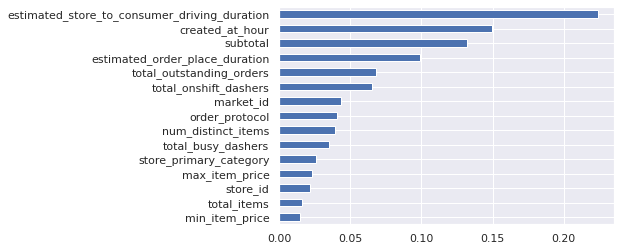

In [57]:
feature_importances = pd.Series(final_model.feature_importances_, index=features)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh')
plt.savefig('./figures/xgb_feat_imp.pdf',bbox_inches='tight')

## Prediction

In [ ]:
final_predictions = final_model.predict(test_processed[features])
test['predicted_duration'] = inv_y(final_predictions)
test['predicted_delivery_time'] = test['created_at'] + pd.to_timedelta(test['predicted_duration'].round(0), unit='s')
test.to_csv('submission.csv', index=False)
test.head()